In [1]:
# import modules
import os # file 
import shutil
import cv2 # opencv for images
import random
import numpy as np
import pandas as pd
import torch
from ultralytics import YOLO #for obeject detection
import albumentations as A # for image augmentation
from albumentations.pytorch import ToTensorV2 # for image formating
import matplotlib.pyplot as plt

# Load Model and Model Names

Using 3 main models:

- YOLO vanilla
- YOLO trained using manual annotations
- YOLO community pre trained on PPEs 


In [2]:
# load pre trained model
model_default = YOLO("../models/yolov8n.pt")
model_usd_g4 = YOLO("../models/best_from_darin.pt")
model_pre_trained = YOLO("../models/ppe.pt")

print(model_default.names)

print("===== USD Group 4 Class names =====")

print(model_usd_g4.names)

print(print("===== Community pre trained ====="))

print(model_pre_trained.names)

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [92]:
# DRAWING METHODS

# Function to get class colors
def getColours(cls_num):
    base_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
    color_index = cls_num % len(base_colors)
    increments = [(1, -2, 1), (-2, 1, -1), (1, -1, 2)]
    color = [base_colors[color_index][i] + increments[color_index][i] * 
    (cls_num // len(base_colors)) % 256 for i in range(3)]
    return tuple(color)


def drawPredictions(predictions, img, class_names): 
    summary = ""
    for p in predictions:
        summary = p.verbose()
        boxes = p.boxes
        for box in boxes:
            if box.conf[0] > 0.4:
                # get coordinates
                [x1, y1, x2, y2] = box.xyxy[0]
                # convert to int
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        
                cls = int(box.cls[0]) # get the class index
        
                colour = getColours(cls)
        
                # draw prediction the rectangle
                cv2.rectangle(img, (x1, y1), (x2, y2), colour, 2)
        
                # put the class name and confidence on the image
                cv2.putText(img, f'{class_names[cls]} {box.conf[0]:.2f}', (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, colour, 2)
    return summary
              

# Predict the list of images and plot on a grid
def predict_ppes_grid(model, list_images, title=""):
    num_images  = len(list_images)
    num_cols    = min(num_images, 3) # minimum 2 columns
    num_rows    = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))
    list_axes = list(axes.flat)
    
    for i in range(num_images):
        file = list_images[i]
        # Open image file for reading and fix color grading
        img = cv2.imread(file) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # perform inference using model and draw predictions
        results = model.predict(img)
        summary = drawPredictions(results, img, model.names)
        list_axes[i].imshow(img)
        print(summary) 
        
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Get predictions from models

Using the loaded models and multiple images as examples, understanding how the models performed

1 person, 1 truck, 1 boat, 
5 persons, 
1 person, 1 truck, 
2 persons, 1 bicycle, 
1 person, 1 train, 
4 persons, 1 bus, 
1 person, 2 cups, 1 chair, 4 couchs, 1 dining table, 1 remote, 2 books, 
1 person, 1 backpack, 1 cup, 1 chair, 1 tv, 
1 person, 2 chairs, 


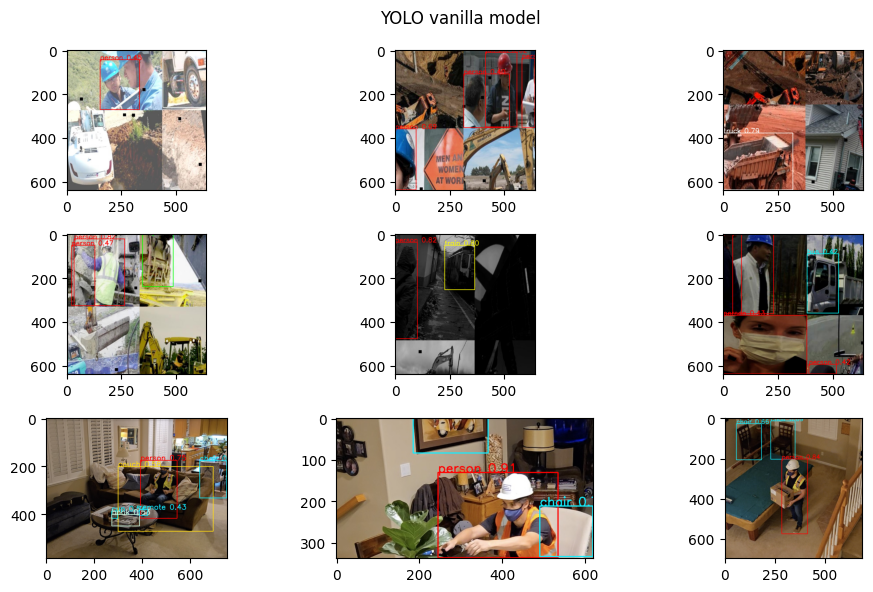

In [93]:
#Manually presenting annotations 
# train files
base_dir="../datasets/images/test/"

image_files=[f"{base_dir}01437_jpg.rf.7839171efbe212f40b2c6ce1f3c8819b.jpg", 
             f"{base_dir}construction-619-_jpg.rf.8181765b21d618233610f2c91a6057a4.jpg",
             f"{base_dir}construction-619-_jpg.rf.dc01af03cac6c0e921cf55d5d8e8465d.jpg",
            f"{base_dir}005310_jpg.rf.83e6f0a246ede1e981765bf75cb7b067.jpg",
            f"{base_dir}2008_008382_jpg.rf.88abdb29b7db6d6218399b4adebdbe66.jpg",
            f"{base_dir}-2270-_png_jpg.rf.4b73cc556e91bc8c587c923e348717f9.jpg",
            "../datasets/custom_images/custom_1.jpg",
            "../datasets/custom_images/custom_2.jpg", 
            "../datasets/custom_images/custom_3.jpg"]

predict_ppes_grid(model_default, image_files, title="YOLO vanilla model")


## USD Group 4 Model

2 Hardhats, 1 NO-Mask, 2 Persons, 3 Machinerys, 
1 Hardhat, 1 NO-Hardhat, 1 NO-Mask, 1 NO-Safety Vest, 4 Persons, 5 Machinerys, 
1 Hardhat, 2 Persons, 6 Machinerys, 
1 Hardhat, 2 Persons, 1 Safety Vest, 4 Machinerys, 
1 NO-Safety Vest, 2 Persons, 1 Machinery, 
2 Hardhats, 1 Mask, 2 NO-Masks, 2 NO-Safety Vests, 4 Persons, 1 Safety Cone, 1 Machinery, 2 Vehicles, 
1 Hardhat, 2 NO-Safety Vests, 1 Machinery, 1 Vehicle, 
1 Hardhat, 1 NO-Safety Vest, 1 Person, 
1 Hardhat, 1 Person, 


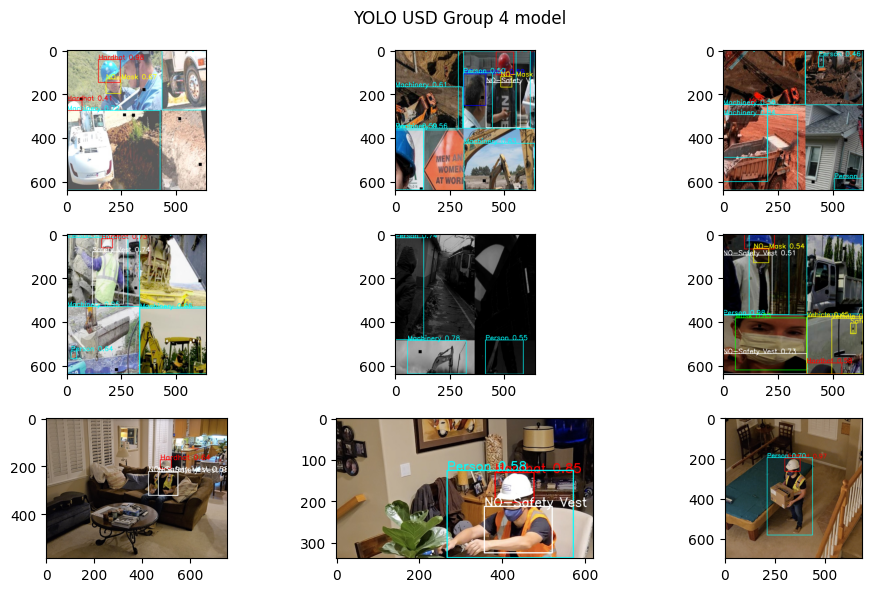

In [94]:
predict_ppes_grid(model_usd_g4, image_files, title="YOLO USD Group 4 model")

## Pre-trained PEE Benchmark

3 Hardhats, 1 NO-Mask, 1 NO-Safety Vest, 1 Person, 2 machinerys, 
2 Hardhats, 1 Mask, 1 NO-Hardhat, 1 NO-Mask, 3 NO-Safety Vests, 4 Persons, 4 machinerys, 
3 Persons, 6 machinerys, 
2 Hardhats, 3 Persons, 2 Safety Vests, 7 machinerys, 
1 Hardhat, 1 NO-Hardhat, 2 NO-Safety Vests, 2 Persons, 1 machinery, 
1 Hardhat, 1 Mask, 1 NO-Hardhat, 1 NO-Mask, 3 NO-Safety Vests, 3 Persons, 1 Safety Cone, 1 machinery, 1 vehicle, 
1 Hardhat, 1 NO-Mask, 1 NO-Safety Vest, 2 Persons, 
1 Hardhat, 1 NO-Mask, 2 Persons, 1 Safety Vest, 
1 Hardhat, 1 NO-Mask, 1 Person, 


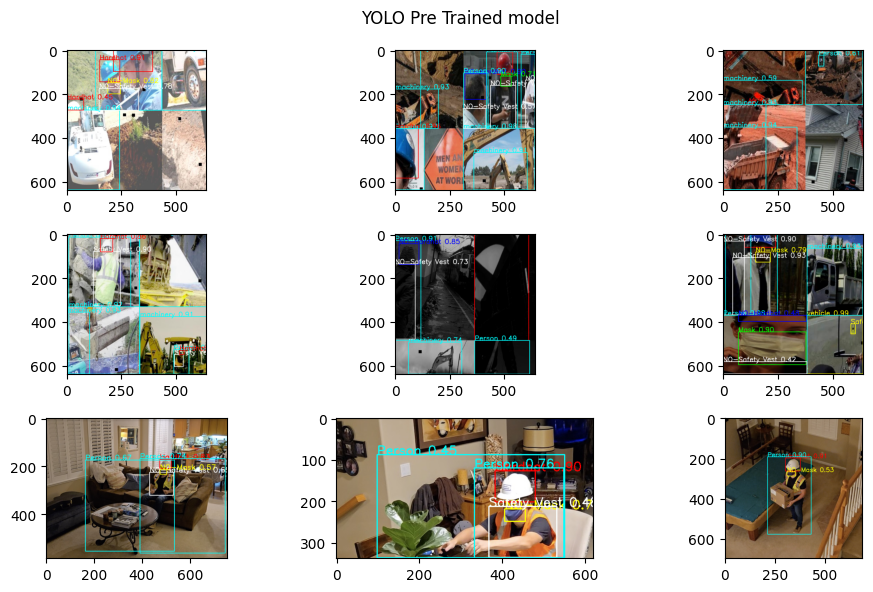

In [95]:
predict_ppes_grid(model_pre_trained, image_files, title="YOLO Pre Trained model")